# NSW Model
We want to model (predict) a Offences to Juvenile Victims using Census features. The steps are:
<ol>
<li>Retrieve Features from NSW Census and Juvenile Victims by LGA</li>
<li>Calculate correlations to select the best features</li>
<li>Create a model (XGBoost)</li>
</ol>


## 1. Retrieve Features from NSW Census and Juvenile Victims by LGA

Load libraries

In [1]:
import pandas as pd
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Import connection functions (pipelines)

In [2]:
# Import the os module
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('G:/My drive/NSW Offences/Scripts/')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

import pipeline

Current working directory: C:\Users\cladi\Downloads
Current working directory: G:\My drive\NSW Offences\Scripts


Read DB connection credential

In [3]:
credentials=pd.read_excel("G:/My drive/NSW Offences/Scripts/connection.xlsx")

Query to get the Juvenile Victims data from our Crime DB

In [4]:
query_string=""" SELECT * FROM prod."2021_census.gcp_all_juvenile_victims.lga"  """
original_data = pipeline.do_query(query_string, credentials.user.iloc[0],credentials.password.iloc[0], credentials.host.iloc[0],credentials.port.iloc[0], credentials.database.iloc[0])
original_data=original_data.set_index('index')
original_data=original_data.T
model_data=original_data.copy()
model_data
model_data=model_data.drop(['lga_code_2021'], axis=1)
model_data.head()
model_data.columns

PostgreSQL connection is closed


Index(['g53b.f_accomfoods_cert', 'g53b.f_accomfoods_id_ns',
       'g53b.f_accomfoods_tot', 'g53b.f_transpostwhse_pd',
       'g53b.f_transpostwhse_gd_gc', 'g53b.f_transpostwhse_bd',
       'g53b.f_transpostwhse_add_d', 'g53b.f_transpostwhse_cert',
       'g53b.f_transpostwhse_id_ns', 'g53b.f_transpostwhse_tot',
       ...
       'domestic_violence_related_assault.rate',
       'nondomestic_violence_related_assault.rate', 'sexual_offences.rate',
       'abduction_and_kidnapping.rate', 'robbery.rate',
       'blackmail_and_extortion.rate',
       'intimidation_stalking_and_harassment.rate',
       'other_offences_against_the_person.rate', 'arson.rate',
       'breach_apprehended_violence_order.rate'],
      dtype='object', name='index', length=17006)

Select "Domestic violence related assault" rate as our target feature

In [5]:
#split df
len(model_data.columns)
bocsardata=model_data.iloc[:,-22:].copy()
censusdata=model_data.iloc[:,:len(model_data.columns)-22].copy()

#select 'domestic violence'
target_feature='nondomestic_violence_related_assault'
model_data=pd.concat([censusdata,bocsardata[[target_feature+'.rate']]], axis=1)
model_data.head()

index,g53b.f_accomfoods_cert,g53b.f_accomfoods_id_ns,g53b.f_accomfoods_tot,g53b.f_transpostwhse_pd,g53b.f_transpostwhse_gd_gc,g53b.f_transpostwhse_bd,g53b.f_transpostwhse_add_d,g53b.f_transpostwhse_cert,g53b.f_transpostwhse_id_ns,g53b.f_transpostwhse_tot,...,g60b.p_tot_professionals,g60b.p_tot_technictrades_w,g60b.p_tot_communpersnlsvc_w,g60b.p_tot_clericaladminis_w,g60b.p_tot_sales_w,g60b.p_tot_mach_oper_drivers,g60b.p_tot_labourers,g60b.p_tot_occu_id_ns,g60b.p_tot_tot,nondomestic_violence_related_assault.rate
Albury,238.0,16.0,448.0,13.0,6.0,25.0,24.0,62.0,5.0,130.0,...,5299.0,3853.0,3634.0,3228.0,2462.0,1779.0,2589.0,435.0,26344.0,0.001747
Armidale Regional,98.0,7.0,179.0,0.0,0.0,9.0,3.0,13.0,0.0,27.0,...,3094.0,1462.0,1574.0,1406.0,1034.0,521.0,1499.0,202.0,12765.0,0.001717
Ballina,206.0,20.0,417.0,0.0,0.0,17.0,11.0,34.0,3.0,65.0,...,4681.0,2859.0,2799.0,2284.0,1999.0,858.0,2083.0,316.0,20775.0,0.000367
Balranald,6.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,88.0,107.0,100.0,99.0,54.0,103.0,165.0,21.0,973.0,0.000000
Bathurst Regional,138.0,15.0,275.0,0.0,0.0,21.0,24.0,35.0,4.0,93.0,...,3898.0,2903.0,3068.0,2426.0,1755.0,1376.0,2211.0,349.0,20457.0,0.001951


Analise the Domestic Violence Rate distributon

<AxesSubplot:xlabel='nondomestic_violence_related_assault.rate', ylabel='Density'>

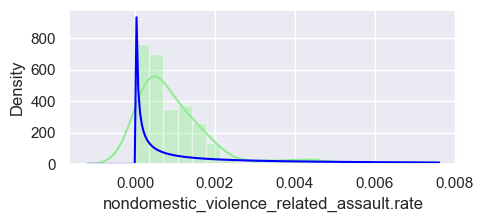

In [6]:
#pre feature engineering
import seaborn as sns
from scipy import stats
sns.set(rc={'figure.figsize':(5,2)})
sns.distplot(model_data[target_feature+'.rate'],color='lightgreen',fit_kws={"color":"blue"},fit=stats.gamma, label="label 1")

Create categories for Domestic Violence Rate (buckets / stratification)

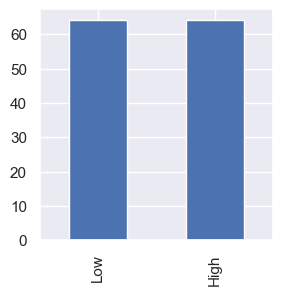

In [7]:
#feature engineering

bin_labels = ['Low', 'High']
model_data[target_feature+'.quantiles'] = pd.qcut(model_data[target_feature+".rate"],
                              q=[0, .5, 1],
                              labels=bin_labels)
model_data.head()
model_data[target_feature+'.quantiles'].value_counts().plot(kind='bar', figsize=(3,3))
model_data=model_data.drop(columns=[target_feature+".rate"])
model_data

#last column
new_cols = [col for col in model_data.columns if col != (target_feature+'.quantiles')] + [(target_feature+'.quantiles')]
model_data = model_data[new_cols]
model_data

#as dummy
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
dummies = lbl.fit_transform(model_data[target_feature+".quantiles"])
model_data[target_feature+".quantiles.bin"]=dummies
model_data.iloc[:, -2:]
model_data=model_data.drop(columns=[target_feature+'.quantiles'])

## 2. Calculate correlations and select the best features

In [8]:
target_feature=target_feature+'.quantiles.bin'
#Do the correlation
#import modin.pandas as pd
corr_data=model_data.copy()
#corr_data=pd.DataFrame(corr_data)
#corr_data=corr_data.values
#corr_table=corr_data.corr().abs()
corr_table=corr_data.corr()
#corr_table=np.corrcoef(corr_data)
corr_table=pd.DataFrame(corr_table)
# Select upper triangle of correlation matrix
upper = corr_table.where(np.triu(np.ones(corr_table.shape), k=1).astype(np.bool))
#select the last row, check if any value is >0.5, keep that column, else drop 
last_col = corr_table.iloc[:,-1]      
last_col=pd.DataFrame(last_col)
last_col.drop(last_col.tail(1).index,inplace=True) # drop last n rows
selected_features=last_col.loc[last_col[target_feature].abs() >= 0.3]
selected_features

,nondomestic_violence_related_assault.quantiles.bin
index,
g53b.f_infomedtelecom_pd,0.336720
g53b.f_infomedtelecom_gd_gc,0.320427
g53b.f_infomedtelecom_bd,0.336392
g53b.f_infomedtelecom_id_ns,0.305991
g53b.f_infomedtelecom_tot,0.324431
...,...
g09h.p_usa_5_14,0.328239
g09h.p_usa_15_24,0.305864
g60b.p20_24_professionals,0.303467


Select the data from the selected features

In [9]:
#select the data from the selected features
selected_model_data=model_data[selected_features.index]
selected_model_data[target_feature]=model_data[target_feature]

## 3. Create a model (XGBoost)

Select and split data

In [10]:
#xgboost
#from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = selected_model_data.loc[:, selected_model_data.columns != target_feature], selected_model_data[target_feature]

# X=model_data.iloc[: , :len(selected_model_data.columns)-1]
# Y=model_data.iloc[: , len(selected_model_data.columns)-1]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


Build model

In [11]:
# XGBoost model
xgb_classifier = xgb.XGBClassifier()

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015],}

# try out every combination of the above values
search = GridSearchCV(xgb_classifier, param_grid, cv=5, verbose=3).fit(X_train, y_train)
#search = GridSearchCV(regressor, param_grid, cv=2, verbose=3).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

xgb_classifier=xgb.XGBClassifier(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

xgb_classifier.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[16:47:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=500;, score=0.706 total time=   2.1s
[16:47:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=500;, score=0.765 total time=   1.8s
[16:47:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\

[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.882 total time=   1.7s
[16:48:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=600;, score=0.706 total time=   2.0s
[16:48:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=600;, score=0.824 total time=   2.1s
[16:48:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\

[CV 5/5] END learning_rate=0.015, max_depth=4, n_estimators=600;, score=0.824 total time=   1.9s
[16:49:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.015, max_depth=4, n_estimators=700;, score=0.706 total time=   2.1s
[16:49:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.015, max_depth=4, n_estimators=700;, score=0.824 total time=   2.1s
[16:49:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croo

[CV 5/5] END learning_rate=0.015, max_depth=5, n_estimators=700;, score=0.824 total time=   2.2s
[16:49:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600}
[16:49:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Evaluate the model

In [12]:
#Next, we'll check the training accuracy with cross-validation and k-fold methods.
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

y_pred = xgb_classifier.predict(X_test)
# df = pd.DataFrame(predictions)
# df=df.astype(float)
# df.loc[df[0] < 0, 0] = 0  
#predictions=df

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred) 
print(cm)
accuracy = accuracy_score(y_test, y_pred)
accuracy
print("The accuracy score: %.2f" % accuracy)
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))


[16:49:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:49:53] WARNING:

Feature importance and features explanation

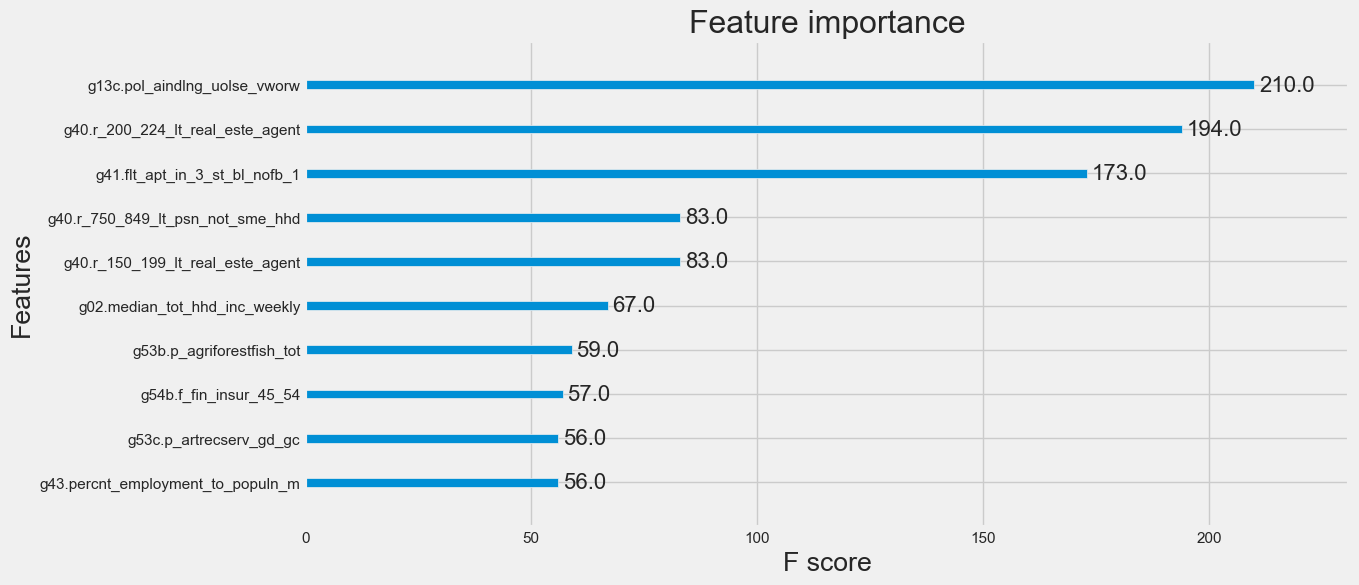

In [13]:
#feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_classifier, max_num_features=10, ax=ax)
plt.show();


Description of the features

In [14]:
#model features
important_features=pd.DataFrame.from_dict(xgb_classifier.get_booster().get_fscore(),orient='index')
important_features=important_features.reset_index()
important_features.columns=["Short","Fscore"]

#features description from census
query_string=""" SELECT "Short", "LongName", "Columnheadingdescriptioninprofile" FROM stage."2021_census.gcp_nsw.dict_transformed"  """
features_desc = pipeline.do_query(query_string, credentials.user.iloc[0],credentials.password.iloc[0], credentials.host.iloc[0],credentials.port.iloc[0], credentials.database.iloc[0])

#merge and shot top 10
result = pd.merge(important_features, features_desc)
result=result.sort_values("Fscore",ascending=False)
top_ten=result.head(10)
result.head(10)

PostgreSQL connection is closed


,Short,Fscore,LongName,Columnheadingdescriptioninprofile
135,g13c.pol_aindlng_uolse_vworw,210.0,g13c.persons_uses_other_language_australian_in...,Uses other language and speaks English: Very w...
32,g40.r_200_224_lt_real_este_agent,194.0,g40.200_224_landlord_type_real_estate_agent,Landlord type: Real estate agent
127,g41.flt_apt_in_3_st_bl_nofb_1,173.0,g41.flat_or_apartment_in_a_three_storey_block_...,Number of bedrooms: One bedroom
35,g40.r_750_849_lt_psn_not_sme_hhd,83.0,g40.750_and_849_landlord_type_person_not_in_sa...,Landlord type: Person not in same household
31,g40.r_150_199_lt_real_este_agent,83.0,g40.150_199_landlord_type_real_estate_agent,Landlord type: Real estate agent
30,g02.median_tot_hhd_inc_weekly,67.0,g02.median_total_household_income_weekly,Median total household income ($/weekly)
6,g53b.p_agriforestfish_tot,59.0,g53b.persons_agriculture_forestry_and_fishing_...,Total|PERSONS
14,g54b.f_fin_insur_45_54,57.0,g54b.females_financial_and_insurance_services_...,Age: 45-54 years|FEMALES
144,g53c.p_artrecserv_gd_gc,56.0,g53c.persons_arts_and_recreation_services_grad...,Graduate Diploma & Graduate Certificate Level|...
75,g43.percnt_employment_to_populn_m,56.0,g43.labour_force_status_percent_employment_to_...,Males


Analysis of Target with features

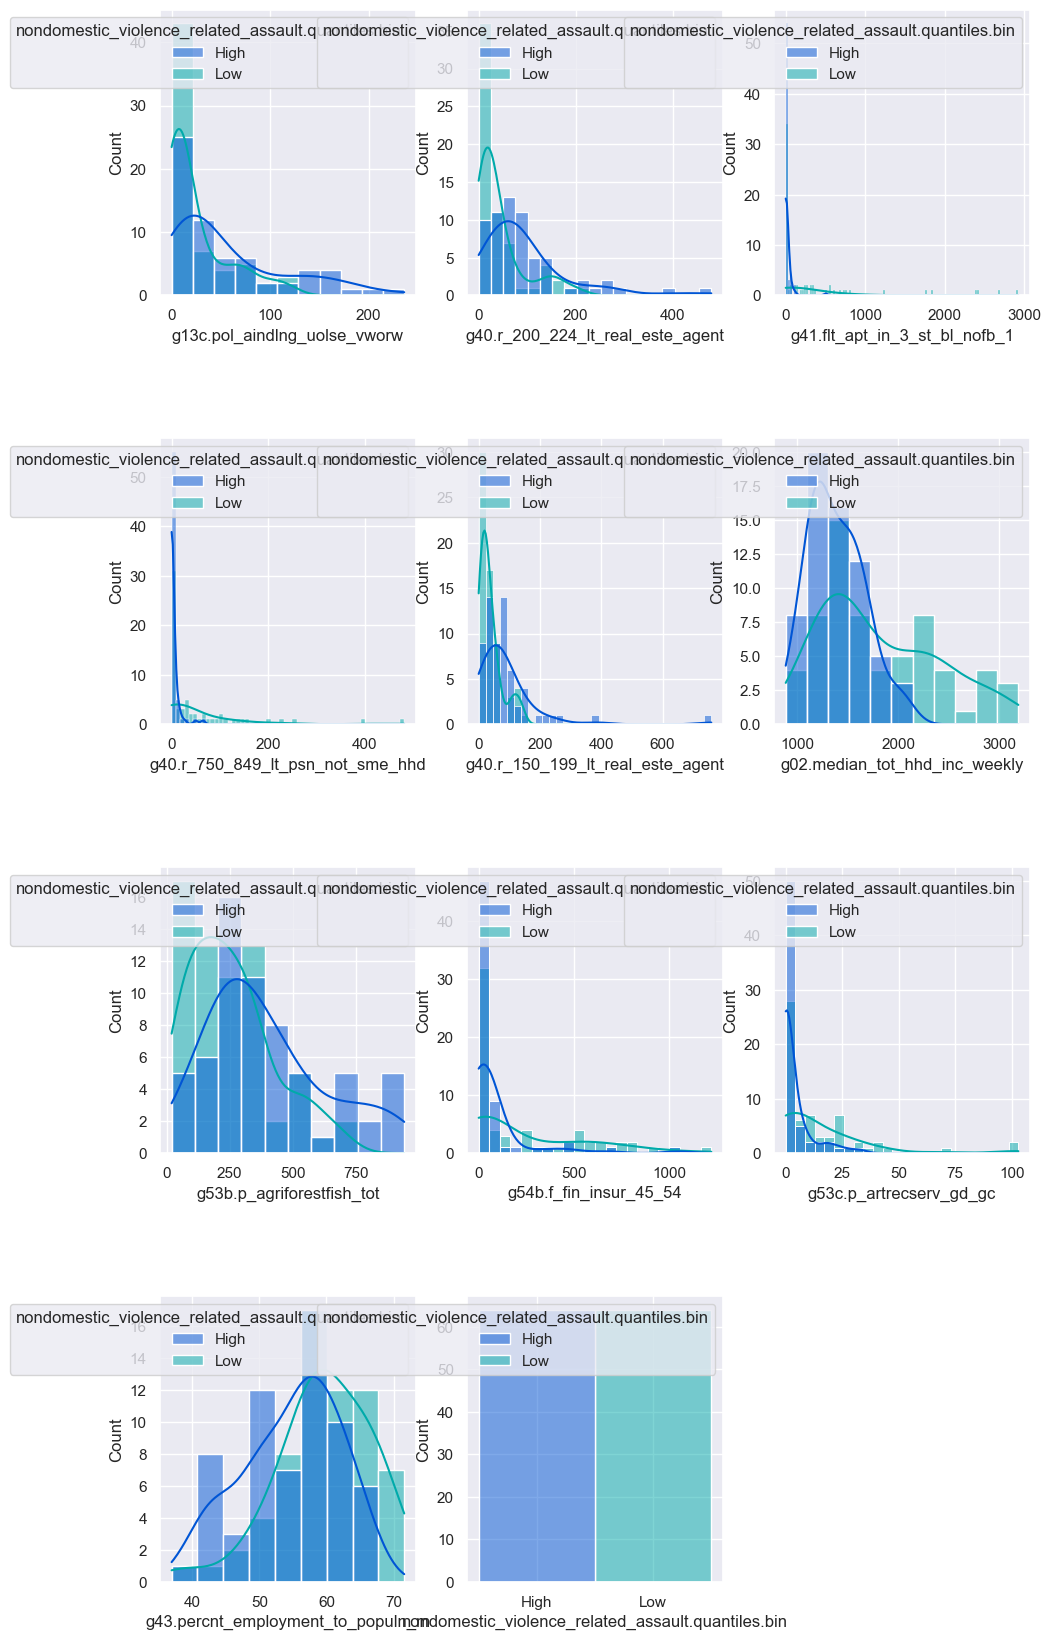

In [15]:
all_data=model_data.T
all_data.reset_index(inplace=True)
top_ten=top_ten.rename(columns={'Short': 'index'})
vis_top_10=pd.merge(top_ten["index"], all_data)
vis_top_10.head()
vis_top_10=vis_top_10.set_index('index')
vis_top_10=vis_top_10.T
vis_top_10[target_feature]=lbl.inverse_transform(model_data[target_feature])
vis_top_10

sns.set(rc={'figure.figsize':(10,30)})
plt.subplots_adjust(hspace = 0.5)
for i, column in enumerate(vis_top_10.columns, 1):
    plt.subplot(6,3,i)
    p=sns.histplot(x=column,data=vis_top_10,hue=target_feature,stat='count',kde=True,palette='winter')
    #p.axes.set_title("\n"+str(column)+"\n",fontsize=15);
